In [423]:
import time
import itertools as it

import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from IPython import display

from Node.functions import *
from Node.Node import Control_node
from Plant.Plant import Plant


# The Idea is that agent strategies can stabilize the behavior of a counterpart. 
# This allows the agent to map changes in their own behavior to the error of a counterpart.
# so we are measuring the ratio between the derivative of behavior change and the error in a counterpart

In [436]:
behav_size = 1
sigmoid_k = 32
sigmoid_b = 2
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# B1 = np.random.rand(1, behav_size)
# B2 = np.random.rand(1, behav_size)
B1 = np.array([[1]])
B2 = np.array([[1]])

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(1, behav_size)
A2 = np.random.rand(1, behav_size)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, behav_size)
R2 = np.random.rand(1, behav_size)

# Initial behavior
behav_1 = np.random.rand(1, behav_size)
behav_2 = np.random.rand(1, behav_size)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([.05])
T2 = np.array([.05])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.00001, error)
    # print(error, control_signal)
    # print(error/control_signal)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0.0001
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.1
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0.0001
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

def reference_update_sigmoid(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)

sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

Seed was: 989
(0, 0)
Conformist  ratio:  0.0019654310530964323
Conformist  ratio:  0.0026589205108951634
(0, 1)
Stubborn  ratio:  2.0670908950090667
Stubborn  ratio:  0.0038776091186874012
(0, 2)
Mixed/Sigmoid  ratio:  1.444125866862935
Mixed/Sigmoid  ratio:  0.018410217738959306

 Sigmoid Model Agents (Error Relative to Expectation)


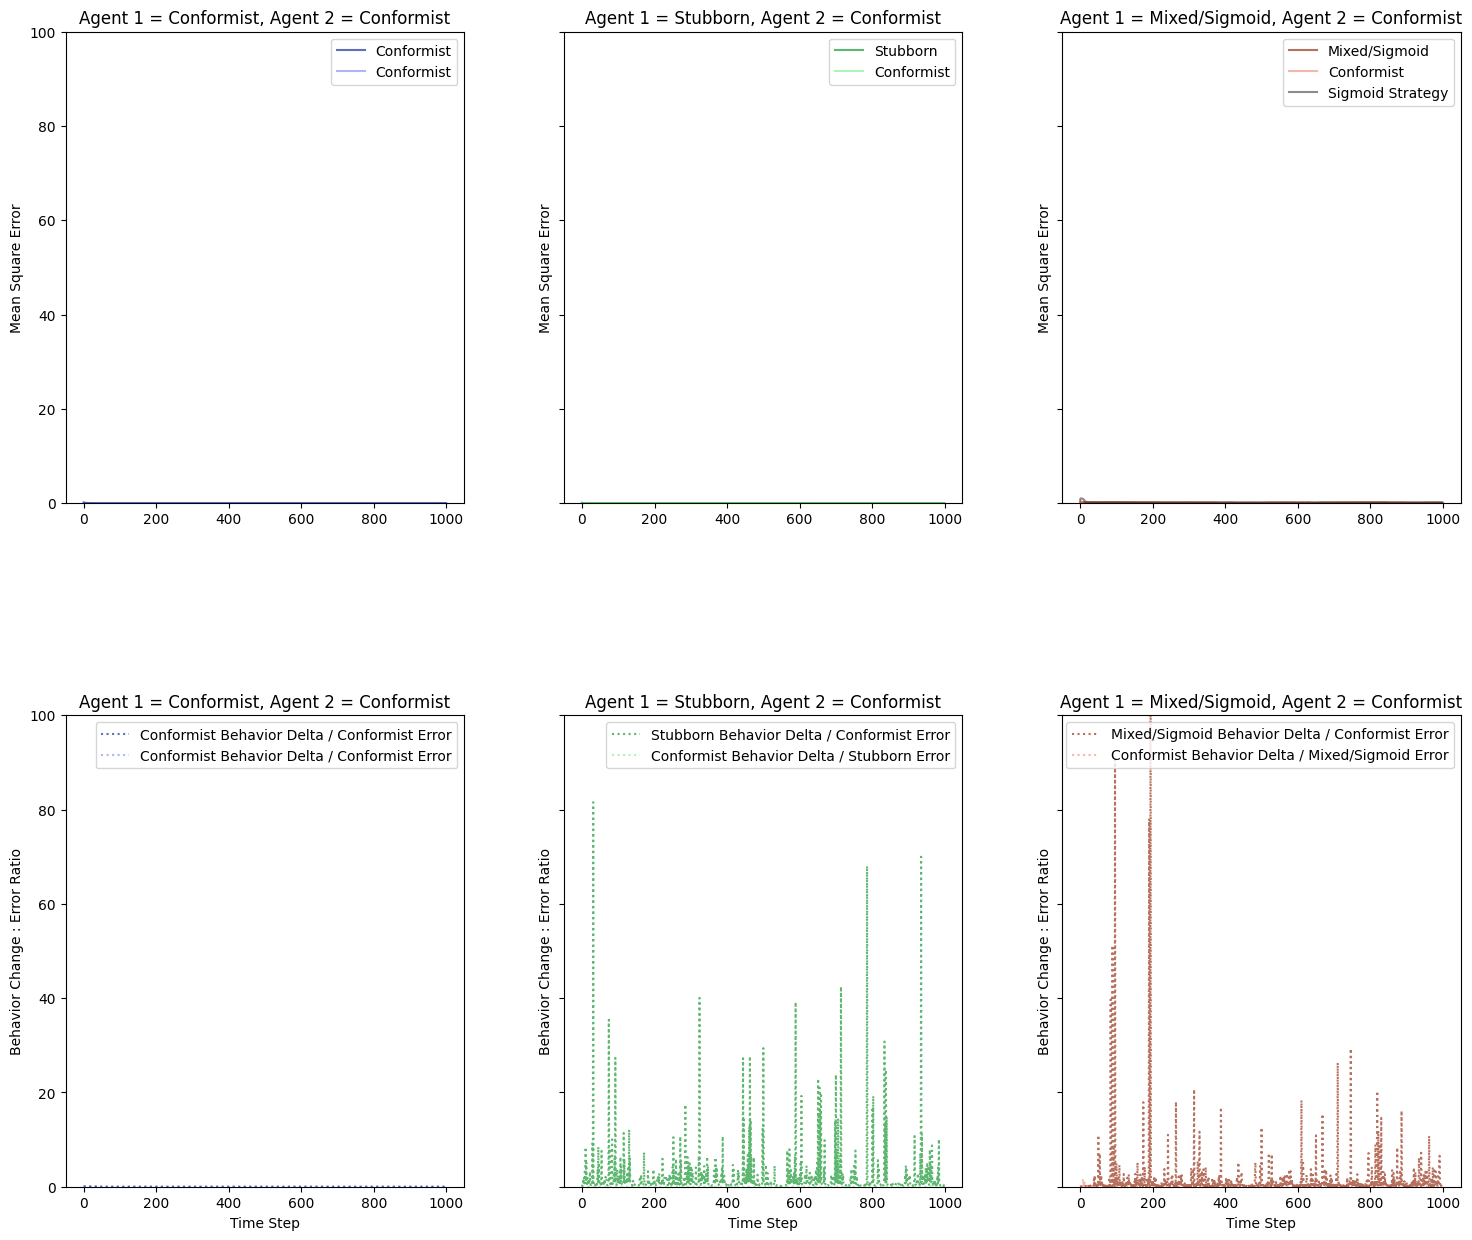

In [465]:
seed = random.randrange(1000)
# seed = 186
# rng = random.Random(seed)
print("Seed was:", seed)
np.random.seed(seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
agents1 = [conformist2, stubborn, sigmoid]
agents2 = [conformist1, conformist1, conformist1]
fig, ax = plt.subplots(nrows*2, ncols, figsize=(w*ncols, h*nrows*3), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
trials = 1000
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]

for ix, param in enumerate(param_vals):
    # experiments
    conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)

    sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))

    b1 = np.random.rand(1, behav_size)
    b2 = np.random.rand(1, behav_size)

    agent1 = agents1[param%3]
    agent2 = agents2[0]
    agent1_error = []
    agent2_error = []
    agent1_raw_error = []
    agent2_raw_error = []
    sigmoid_value = []
    agent1_behaviors = []
    agent2_behaviors = []
    agent1_control = []
    agent2_control = []
    agent1_reference = []
    agent2_reference = []
    for t in range(trials):
        color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
        color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
        #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
        #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        agent1_control.append(agent1.get_output())
        agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)
        
        agent1_behaviors.append(b1)
        agent2_behaviors.append(b2)

        # agent1_error.append(np.absolute(agent1.get_error()))
        # agent2_error.append(np.absolute(agent2.get_error()))
        agent1_raw_error.append(agent1.get_error()[0][0])
        agent2_raw_error.append(agent2.get_error()[0][0])
        # if b1[0][0] == 0.0 or b1[0][0] == 1.0:
        #   agent1_raw_error.append(b1[0][0]+0.001)
        # else:
        #   agent1_raw_error.append(agent1.get_error()[0][0])
        # if b2[0][0] == 0.0 or b2[0][0] == 1.0:
        #    agent2_raw_error.append(b2[0][0]+0.001)
        # else:
        #   agent2_raw_error.append(agent2.get_error()[0][0])
        agent1_error.append(np.sum(np.square(agent1.get_error()[0]))/len(agent1.get_error()[0]))
        agent2_error.append(np.sum(np.square(agent2.get_error()[0]))/len(agent2.get_error()[0]))
        if agents_label[param] == "Mixed/Sigmoid": 
          sqr_error = np.square(agent2.get_error()[0])
          sigmoid_value.append(shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))

        agent1_reference.append(agent1.get_reference()[0])
        agent2_reference.append(agent2.get_reference()[0])

    ai = tups[ix]
    print(ai)
    color = colors[param]
    color_c = colors_c[param]
    # plots
    ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    if agents_label[param] == "Mixed/Sigmoid": 
      ax[ai].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
    #   print(sigmoid_value)
    ax[ai].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    # ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")
    # ax[ai].set_xlabel("Time Step")

    # derivative charts
    dx = 1
    # b1_flat = [i[0] for i in agent1_control]
    # b2_flat = [i[0] for i in agent2_control]
    b1_flat = [i[0][0]for i in agent1_behaviors]
    b2_flat = [i[0][0]for i in agent2_behaviors]
    # d_behav1 = abs(np.gradient(b1_flat, dx))
    # d_behav2 = abs(np.gradient(b2_flat, dx))
    d_behav1 = np.insert(np.diff(b1_flat, dx), 0, 0)
    d_behav2 = np.insert(np.diff(b2_flat, dx), 0, 0)
    agent1_raw_error.insert(-1, 1)
    agent2_raw_error.insert(-1, 1)
    agent1_raw_error_shifted = agent1_raw_error[1:]
    agent2_raw_error_shifted = agent2_raw_error[1:]
    if agents_label[param] == 'Stubborn':
       saved = d_behav1/agent1_error
      #  print(agent2_error/(d_behav2+0.01))
    print(agents_label[param%3], " ratio: ", np.average(abs(d_behav1/agent2_raw_error_shifted)))
    print(agents_label[param%3], " ratio: ", np.average(abs(d_behav2/agent1_raw_error_shifted)))
    # ax[(ai[0]+1,ai[1])].plot(time, d_behav1, color=color, linestyle='--', label="{} Change in Behavior".format(agents_label[param]))
    # ax[(ai[0]+1,ai[1])].plot(time, d_behav2, color=color_c, linestyle='--', label="Conformist Change in Behavior")
    # ax[(ai[0]+1,ai[1])].plot(time, agent1_error, color=color,  label="{} Error".format(agents_label[param]))
    # ax[(ai[0]+1,ai[1])].plot(time, agent2_error, color=color_c, label="Conformist Error")
    ax[(ai[0]+1,ai[1])].plot(time, abs(d_behav1/agent2_raw_error_shifted), color=color, linestyle=':', label="{} Behavior Delta / Conformist Error".format(agents_label[param]))
    ax[(ai[0]+1,ai[1])].plot(time, abs(d_behav2/agent1_raw_error_shifted), color=color_c, linestyle=':', label="Conformist Behavior Delta / {} Error".format(agents_label[param]))
    # if agents_label[param] == "Mixed/Sigmoid": 
    #   ax[(ai[0]+1,ai[1])].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
    #   print(sigmoid_value)
    ax[(ai[0]+1,ai[1])].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[(ai[0]+1,ai[1])].legend()
    ax[ai].set_ylim(0,100)
    # ax[ai].set_xlim(0,t)
    # ax[(ai[0]+1,ai[1])].set_ylim(0,5)
    ax[(ai[0]+1,ai[1])].tick_params(axis='x')
    ax[(ai[0]+1,ai[1])].tick_params(axis='y')
    ax[(ai[0]+1,ai[1])].set_ylabel("Behavior Change : Error Ratio")
    ax[(ai[0]+1,ai[1])].set_xlabel("Time Step")
# plt.text(-55, 4, "Different Agent Strategies for Stabilizing Behavior", fontsize=14)
# plt.text(-55, 1.85, "Tracing the Ratio of Change in Behavior and the Error of a Counterpart", fontsize=14)
print("\n Sigmoid Model Agents (Error Relative to Expectation)")
# print("Agent 1 base reference: {}".format(R1))
# print("Agent 2 base reference: {}".format(R2))
plt.show()

In [471]:
behav_size = 1
sigmoid_k = 200000000000
sigmoid_b = 20
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# B1 = np.random.rand(1, behav_size)
# B2 = np.random.rand(1, behav_size)
B1 = np.array([[1]])
B2 = np.array([[1]])

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(1, behav_size)
A2 = np.random.rand(1, behav_size)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, behav_size)
R2 = np.random.rand(1, behav_size)

# Initial behavior
behav_1 = np.random.rand(1, behav_size)
behav_2 = np.random.rand(1, behav_size)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([.05])
T2 = np.array([.05])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.00001, error)
    # print(error, control_signal)
    # print(error/control_signal)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0.0001
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.1
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0.0001
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

def reference_update_sigmoid(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)

sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

Seed was: 773
Conformist ratio:  0.0011264043050015701
Conformist ratio:  0.014511265911317031
Conformist + Conformist covariance: [[1.14448841e-06 2.29918245e-05]
 [2.29918245e-05 1.62143895e-03]]
Conformist & Conformist covariance: [[1.57185034e-06 2.23176157e-05]
 [2.23176157e-05 1.45256483e-03]]
Conformist & Conformist Pearson R: 0.533724864754622
Conformist & Conformist  Pearson R: 0.46706189347688787
---
Stubborn ratio:  2.148971354635529
Conformist ratio:  0.004443704916767958
Stubborn + Conformist covariance: [[6.90280510e-05 4.16698036e-05]
 [4.16698036e-05 3.47239727e-03]]
Conformist & Stubborn covariance: [[6.47045922e-06 3.32014696e-05]
 [3.32014696e-05 9.41981704e-03]]
Stubborn & Conformist Pearson R: 0.08511261702829369
Conformist & Stubborn  Pearson R: 0.13448335100097672
---
Mixed/Sigmoid ratio:  0.25766833339956985
Conformist ratio:  nan
Mixed/Sigmoid + Conformist covariance: [[3.57283627e-05 1.41475034e-05]
 [1.41475034e-05 1.48653326e-03]]
Conformist & Mixed/Sigmoid 

/var/folders/m2/79c0250s6dv437ybqm3rcw1r0000gp/T/ipykernel_31271/1629385843.py:139: RuntimeWarning: invalid value encountered in divide
  print(agents_label[0], "ratio: ", np.average(abs(d_behav2/agent1_raw_error_shifted)))


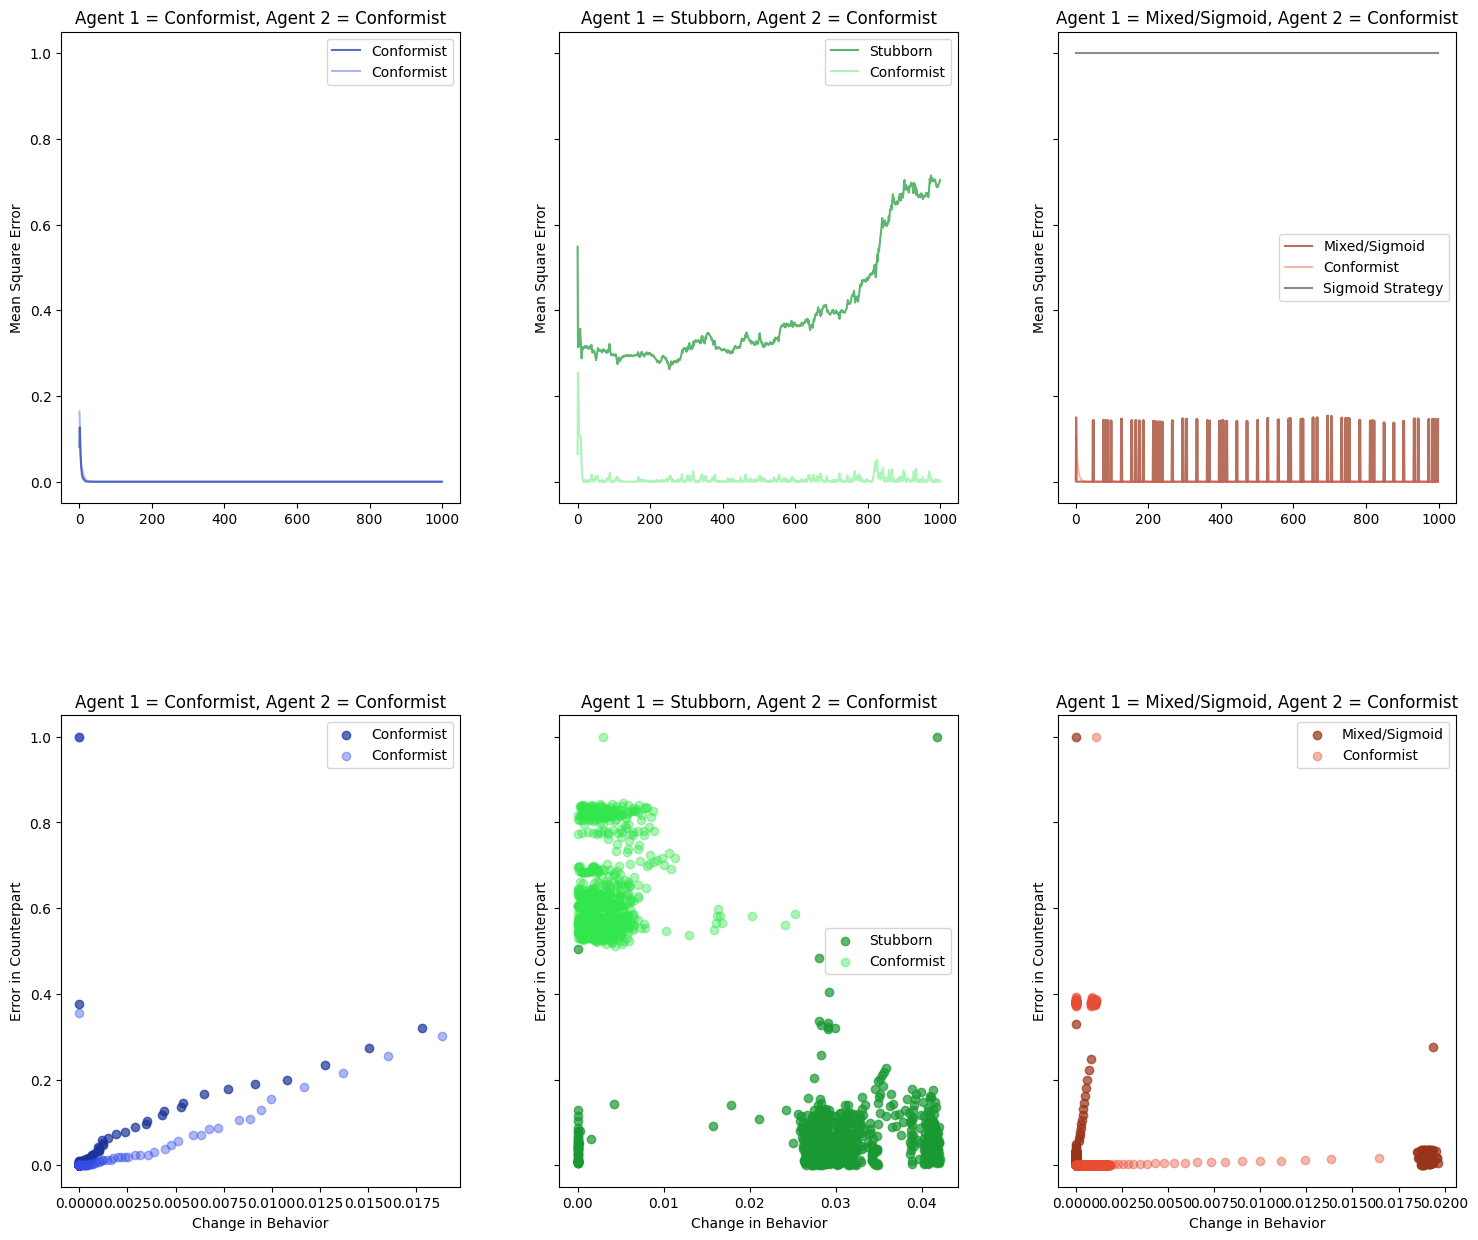

In [481]:
seed = random.randrange(1000)
# seed = 186
# rng = random.Random(seed)
print("Seed was:", seed)
np.random.seed(seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
agents1 = [conformist2, stubborn, sigmoid]
agents2 = [conformist1, conformist1, conformist1]
fig, ax = plt.subplots(nrows*2, ncols, figsize=(w*ncols, h*nrows*3), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
trials = 1000
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]

for ix, param in enumerate(param_vals):
    # experiments
    conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)

    sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))

    b1 = np.random.rand(1, behav_size)
    b2 = np.random.rand(1, behav_size)

    agent1 = agents1[param%3]
    agent2 = agents2[0]
    agent1_error = []
    agent2_error = []
    agent1_raw_error = []
    agent2_raw_error = []
    sigmoid_value = []
    agent1_behaviors = []
    agent2_behaviors = []
    agent1_control = []
    agent2_control = []
    agent1_reference = []
    agent2_reference = []
    for t in range(trials):
        color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
        color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
        #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
        #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        agent1_control.append(agent1.get_output())
        agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)
        
        agent1_behaviors.append(b1)
        agent2_behaviors.append(b2)

        # agent1_error.append(np.absolute(agent1.get_error()))
        # agent2_error.append(np.absolute(agent2.get_error()))
        agent1_raw_error.append(agent1.get_error()[0][0])
        agent2_raw_error.append(agent2.get_error()[0][0])
        # if b1[0][0] == 0.0 or b1[0][0] == 1.0:
        #   agent1_raw_error.append(b1[0][0]+0.001)
        # else:
        #   agent1_raw_error.append(agent1.get_error()[0][0])
        # if b2[0][0] == 0.0 or b2[0][0] == 1.0:
        #    agent2_raw_error.append(b2[0][0]+0.001)
        # else:
        #   agent2_raw_error.append(agent2.get_error()[0][0])
        agent1_error.append(np.sum(np.square(agent1.get_error()[0]))/len(agent1.get_error()[0]))
        agent2_error.append(np.sum(np.square(agent2.get_error()[0]))/len(agent2.get_error()[0]))
        if agents_label[param] == "Mixed/Sigmoid": 
          sqr_error = np.square(agent2.get_error()[0])
          sigmoid_value.append(shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))

        agent1_reference.append(agent1.get_reference()[0])
        agent2_reference.append(agent2.get_reference()[0])

    ai = tups[ix]
    color = colors[param]
    color_c = colors_c[param]
    # plots
    ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    if agents_label[param] == "Mixed/Sigmoid": 
      ax[ai].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
    #   print(sigmoid_value)
    ax[ai].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    # ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")
    # ax[ai].set_xlabel("Time Step")

    # derivative charts
    dx = 1
    # b1_flat = [i[0] for i in agent1_control]
    # b2_flat = [i[0] for i in agent2_control]
    b1_flat = [i[0][0]for i in agent1_behaviors]
    b2_flat = [i[0][0]for i in agent2_behaviors]
    # d_behav1 = abs(np.gradient(b1_flat, dx))
    # d_behav2 = abs(np.gradient(b2_flat, dx))
    d_behav1 = np.insert(np.diff(b1_flat, dx), 0, 0)
    d_behav2 = np.insert(np.diff(b2_flat, dx), 0, 0)
    agent1_raw_error.insert(-1, 1)
    agent2_raw_error.insert(-1, 1)
    agent1_raw_error_shifted = agent1_raw_error[1:]
    agent2_raw_error_shifted = agent2_raw_error[1:]

    print(agents_label[param%3], "ratio: ", np.average(abs(d_behav1/agent2_raw_error_shifted)))
    print(agents_label[0], "ratio: ", np.average(abs(d_behav2/agent1_raw_error_shifted)))
    print(agents_label[param%3], "+ Conformist covariance:", np.cov(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted)))
    print(agents_label[0], "&",agents_label[param%3], "covariance:", np.cov(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted)))
    print(agents_label[param%3], "& Conformist Pearson R:", np.corrcoef(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted))[0][1])
    print(agents_label[0], "&", agents_label[param%3], " Pearson R:", np.corrcoef(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted))[0][1])
    print("---")

    ax[(ai[0]+1,ai[1])].scatter(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted), color=color, label="{}".format(agents_label[param]))
    ax[(ai[0]+1,ai[1])].scatter(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted), color=color_c, label="Conformist")

    ax[(ai[0]+1,ai[1])].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[(ai[0]+1,ai[1])].legend()
    # ax[ai].set_ylim(0,100)
    # ax[ai].set_xlim(0,t)
    # ax[(ai[0]+1,ai[1])].set_ylim(0,5)
    ax[(ai[0]+1,ai[1])].tick_params(axis='x')
    ax[(ai[0]+1,ai[1])].tick_params(axis='y')
    ax[(ai[0]+1,ai[1])].set_ylabel("Error in Counterpart")
    ax[(ai[0]+1,ai[1])].set_xlabel("Change in Behavior")

plt.show()

In [439]:
corr1 = abs(d_behav1/agent2_raw_error_shifted)
corr2 = abs(d_behav2/agent1_raw_error_shifted)
for i in range(len(corr1)):
  if corr1[i] > 5:
    print("d_behav1 from trial {}".format(i-2))
    print(d_behav1[i-2:i+2])
    print("agent1_behaviors {}".format(i-2))
    print(agent1_behaviors[i-2:i+2])
    print("agent2_reference {}".format(i-2))
    print(agent2_reference[i-2:i+2])
    print("agent2_raw_error from trial {}".format(i-2))
    print(agent2_raw_error_shifted[i-2:i+2])
    print("")
    print("agent1_reference {}".format(i-2))
    print(agent1_reference[i-2:i+2])
    print("agent2_behaviors {}".format(i-2))
    print(agent2_behaviors[i-2:i+2])
    print("")
    print("")


d_behav1 from trial 91
[-3.31624763e-06  0.00000000e+00  2.54159111e-02  0.00000000e+00]
agent1_behaviors 91
[array([[0.0001]]), array([[0.0001]]), array([[0.02551591]]), array([[0.02551591]])]
agent2_reference 91
[array([0.02805181]), array([0.02525663]), array([0.02274097]), array([0.02301846])]
agent2_raw_error from trial 91
[0.0279518097415156, 0.02515662876736404, -0.002774945240776594, -0.0024974507166989346]

agent1_reference 91
[array([0.96958754]), array([0.45932905]), array([0.9665552]), array([0.45932255])]
agent2_behaviors 91
[array([[0.96904486]]), array([[0.96764727]]), array([[0.9689051]]), array([[0.9689051]])]


d_behav1 from trial 141
[-0.02488973 -0.00024099 -0.02497008  0.        ]
agent1_behaviors 141
[array([[0.12641801]]), array([[0.12617702]]), array([[0.10120694]]), array([[0.10120694]])]
agent2_reference 141
[array([0.09156018]), array([0.09504596]), array([0.09815907]), array([0.09846386])]
agent2_raw_error from trial 141
[-0.03485783191300132, -0.03113105639

Seed was: 186
Conformist (vs Conformist) variance: 1.219836343815127
Conformist (vs Stubborn) variance: 0.010005497864925883
Conformist (vs Sigmoid/Mixed) variance: 0.6363871110463291
Stubborn (vs Conformist) variance: 14.765316231858481
Sigmoid/Mixed (vs Conformist) variance: 18.073359560306585


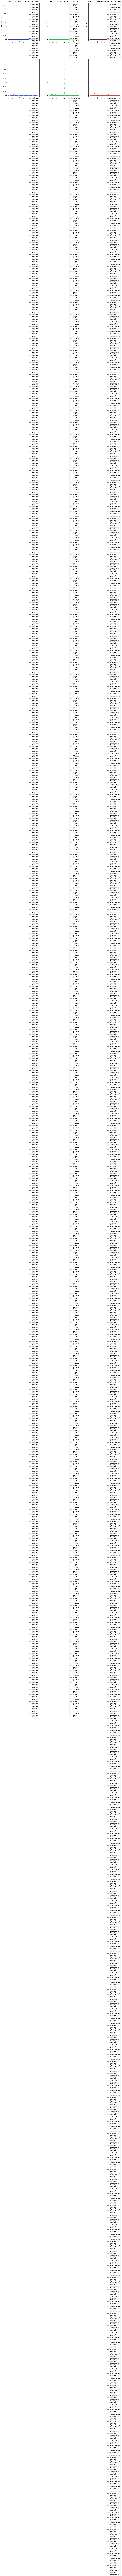

In [431]:
# seed = random.randrange(1000)
seed = 186
rng = random.Random(seed)
print("Seed was:", seed)
np.random.seed(seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
agents1 = [conformist2, stubborn, sigmoid]
agents2 = [conformist1, conformist1, conformist1]
fig, ax = plt.subplots(nrows*2, ncols, figsize=(w*ncols, h*nrows*3), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
trials = 200
runs = 500
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]

for r in range(runs):
  conformist_var = []
  conformist_var_stubborn = []
  stubborn_var_conformist = []
  conformist_var_mixed = []
  mixed_var_conformist = []
  for ix, param in enumerate(param_vals):
      # experiments
      conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
      system_estimate=A1, reference=R1, init_behavior=behav_1)

      conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
      system_estimate=A1, reference=R1, init_behavior=behav_1)

      stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
      system_estimate=A2, reference=R2, init_behavior=behav_2)

      sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
      system_estimate=A1, reference=R1, init_behavior=behav_1)

      plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
      plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))

      b1 = np.random.rand(1, behav_size)
      b2 = np.random.rand(1, behav_size)

      agent1 = agents1[param%3]
      agent2 = agents2[0]
      agent1_error = []
      agent2_error = []
      agent1_raw_error = []
      agent2_raw_error = []
      sigmoid_value = []
      agent1_behaviors = []
      agent2_behaviors = []
      agent1_control = []
      agent2_control = []
      agent1_reference = []
      agent2_reference = []
      for t in range(trials):
          color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
          color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
          #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
          #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
          b1_control = agent1.go(b2)   
          b2_control = agent2.go(b1)

          agent1_control.append(agent1.get_output())
          agent2_control.append(agent2.get_output())

          b1 = plant1.transition(b1_control)
          b2 = plant2.transition(b2_control)
          
          agent1_behaviors.append(b1)
          agent2_behaviors.append(b2)

          # agent1_error.append(np.absolute(agent1.get_error()))
          # agent2_error.append(np.absolute(agent2.get_error()))
          agent1_raw_error.append(agent1.get_error()[0][0])
          agent2_raw_error.append(agent2.get_error()[0][0])
          # if b1[0][0] == 0.0 or b1[0][0] == 1.0:
          #   agent1_raw_error.append(b1[0][0]+0.001)
          # else:
          #   agent1_raw_error.append(agent1.get_error()[0][0])
          # if b2[0][0] == 0.0 or b2[0][0] == 1.0:
          #    agent2_raw_error.append(b2[0][0]+0.001)
          # else:
          #   agent2_raw_error.append(agent2.get_error()[0][0])
          agent1_error.append(np.sum(np.square(agent1.get_error()[0]))/len(agent1.get_error()[0]))
          agent2_error.append(np.sum(np.square(agent2.get_error()[0]))/len(agent2.get_error()[0]))
          if agents_label[param] == "Mixed/Sigmoid": 
            sqr_error = np.square(agent2.get_error()[0])
            sigmoid_value.append(shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))

          agent1_reference.append(agent1.get_reference()[0])
          agent2_reference.append(agent2.get_reference()[0])

      ai = tups[ix]
      color = colors[param]
      color_c = colors_c[param]
      # plots
      ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
      ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
      if agents_label[param] == "Mixed/Sigmoid": 
        ax[ai].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
      #   print(sigmoid_value)
      ax[ai].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
      ax[ai].legend()
      # ax[ai].set_xlim(0,t)
      # ax[ai].set_ylim(0,1)
      ax[ai].tick_params(axis='x')
      ax[ai].tick_params(axis='y')
      ax[ai].set_ylabel("Mean Square Error")
      # ax[ai].set_xlabel("Time Step")

      # derivative charts
      dx = 1
      # b1_flat = [i[0] for i in agent1_control]
      # b2_flat = [i[0] for i in agent2_control]
      b1_flat = [i[0][0]for i in agent1_behaviors]
      b2_flat = [i[0][0]for i in agent2_behaviors]
      # d_behav1 = abs(np.gradient(b1_flat, dx))
      # d_behav2 = abs(np.gradient(b2_flat, dx))
      d_behav1 = np.insert(np.diff(b1_flat, dx), 0, 0)
      d_behav2 = np.insert(np.diff(b2_flat, dx), 0, 0)
      agent1_raw_error.insert(-1, 1)
      agent2_raw_error.insert(-1, 1)
      agent1_raw_error_shifted = agent1_raw_error[1:]
      agent2_raw_error_shifted = agent2_raw_error[1:]
      if agents_label[param] == 'Stubborn':
        saved = d_behav1/agent1_error
        #  print(agent2_error/(d_behav2+0.01))
      # ax[(ai[0]+1,ai[1])].plot(time, d_behav1, color=color, linestyle='--', label="{} Change in Behavior".format(agents_label[param]))
      # ax[(ai[0]+1,ai[1])].plot(time, d_behav2, color=color_c, linestyle='--', label="Conformist Change in Behavior")
      # ax[(ai[0]+1,ai[1])].plot(time, agent1_error, color=color,  label="{} Error".format(agents_label[param]))
      # ax[(ai[0]+1,ai[1])].plot(time, agent2_error, color=color_c, label="Conformist Error")
      ax[(ai[0]+1,ai[1])].plot(time, abs(d_behav1/agent2_raw_error_shifted), color=color, linestyle=':', label="{} Behavior Delta / Conformist Error".format(agents_label[param]))
      ax[(ai[0]+1,ai[1])].plot(time, abs(d_behav2/agent1_raw_error_shifted), color=color_c, linestyle=':', label="Conformist Behavior Delta / {} Error".format(agents_label[param]))
      if ai[1] == 0:
        conformist_var.append(abs(d_behav1/agent2_raw_error_shifted))
        conformist_var.append(abs(d_behav2/agent1_raw_error_shifted))
      elif ai[1] == 1:
        conformist_var_stubborn.append(abs(d_behav2/agent1_raw_error_shifted))
        stubborn_var_conformist.append(abs(d_behav1/agent2_raw_error_shifted))
      elif ai[1] == 2:
        conformist_var_mixed.append(abs(d_behav2/agent1_raw_error_shifted))
        mixed_var_conformist.append(abs(d_behav1/agent2_raw_error_shifted))
         
      # if agents_label[param] == "Mixed/Sigmoid": 
      #   ax[(ai[0]+1,ai[1])].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
      #   print(sigmoid_value)
      # ax[(ai[0]+1,ai[1])].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
      # ax[(ai[0]+1,ai[1])].legend()
      # ax[ai].set_xlim(0,t)
      # ax[(ai[0]+1,ai[1])].set_ylim(0,5)
      # ax[(ai[0]+1,ai[1])].tick_params(axis='x')
      # ax[(ai[0]+1,ai[1])].tick_params(axis='y')
      # ax[(ai[0]+1,ai[1])].set_ylabel("Behavior Change : Error Ratio")
      # ax[(ai[0]+1,ai[1])].set_xlabel("Time Step")
  # plt.text(-55, 4, "Different Agent Strategies for Stabilizing Behavior", fontsize=14)
  # plt.text(-55, 1.85, "Tracing the Ratio of Change in Behavior and the Error of a Counterpart", fontsize=14)
  # print("\n Sigmoid Model Agents (Error Relative to Expectation)")
  # print("Agent 1 base reference: {}".format(R1))
  # print("Agent 2 base reference: {}".format(R2))
  # plt.show()
print ("Conformist (vs Conformist) variance: {}".format(np.var(conformist_var)))
print ("Conformist (vs Stubborn) variance: {}".format(np.var(conformist_var_stubborn)))
print ("Conformist (vs Sigmoid/Mixed) variance: {}".format(np.var(conformist_var_mixed)))
print ("Stubborn (vs Conformist) variance: {}".format(np.var(stubborn_var_conformist)))
print ("Sigmoid/Mixed (vs Conformist) variance: {}".format(np.var(mixed_var_conformist)))

In [256]:
print(agent2_behaviors[10:14])
print(agent2_control[10:14])
print(b2_flat[10:14])
print(d_behav2[10:14])
print(agent2_raw_error[10:14])
print("derivative / error ratio: ", (d_behav2/agent2_raw_error)[10:14])


[array([[-54.19567975]]), array([[-131.38055183]]), array([[-249.66739224]]), array([[-278.94067653]])]
[array([48.82045554]), array([-77.18487208]), array([-118.28684041]), array([-29.27328429])]
[-54.19567974541204, -131.38055182619797, -249.66739224066419, -278.94067653289784]
[  48.82045554  -77.18487208 -118.28684041  -29.27328429]
[-48.82045554175887, 77.18487208078594, 118.28684041446623, 29.27328429223367]
derivative / error ratio:  [-1. -1. -1. -1.]


In [236]:
print(b1_flat[1:5])
print(np.diff(b1_flat, dx)[1:5])

[0.45591276299899886, 1.0, 0.9223254530779923, 0.4530074498867381]
[ 0.54408724 -0.07767455 -0.469318    0.        ]


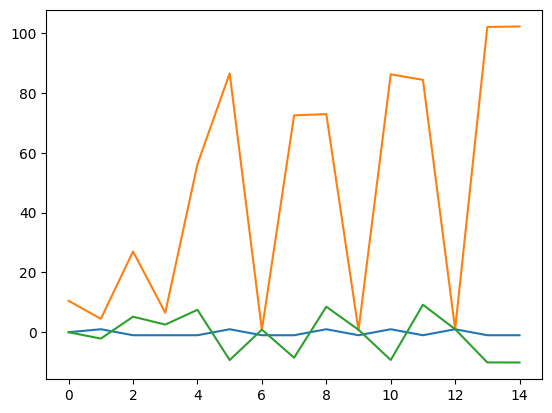

[-0.  1. -1. -1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.]


In [254]:
x = range(15)  # Y-axis points
# print(agent2_error[7:10])
# print(d_behav2[9])
plt.plot(x, (d_behav2/agent2_raw_error)[0:15])  # Plot the c
plt.plot(x, agent2_error[0:15])  # Plot the c
plt.plot(x, d_behav2[0:15])  # Plot the chart
plt.show()  # display
print((d_behav2/agent2_raw_error)[0:15])


[ 2.66543271  0.30293091  0.43268092  0.          0.37865038  0.75710236
  0.49743679  1.11540308  0.19812062  0.97299675 11.53841367  0.45137994
  2.0076206   0.22662885  0.78119335  0.05686527  0.53858439  1.57342423
  0.          0.40691135]


ValueError: x and y must have same first dimension, but have shapes (100,) and (20,)

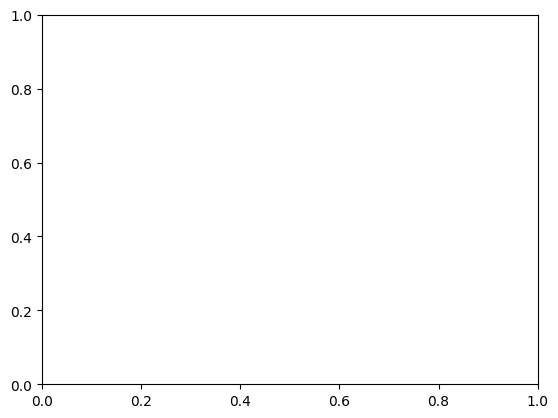

In [210]:
# define data values
y = saved
print(saved)
# y = agent2_error/(d_behav2+0.01) # X-axis points
x = range(100)  # Y-axis points

plt.plot(x, y)  # Plot the chart
plt.show()  # display
# print(agent2_error/(d_behav2+0.01))